# Nurse Scheduling Problem

**Note:** You can download the repository containing this example [here](https://github.com/alberts96/A nurse scheduling problem solved with Gurobi/master.zip). In order to run this Jupyter Notebook properly, you must have a Gurobi license. If you do not have one, you can request an [evaluation license](https://www.gurobi.com/downloads/request-an-evaluation-license/?utm_source=Github&utm_medium=website_JupyterME&utm_campaign=CommercialDataScience) as a *commercial user*, or download a [free license](https://www.gurobi.com/academia/academic-program-and-licenses/?utm_source=Github&utm_medium=website_JupyterME&utm_campaign=AcademicDataScience) as an *academic user*.

## Problem Description

A large hospital has to cover a set of day-care activities with the available nurses.Each nurse can perform different subsets of the activities, which are implicitly definedby time and skill constraints.  In particular, for each activity the starting time andthe ending time are given, so it is known whether or not it is possible for the samenurse to perform both in sequence (it is assumed that it takes a short enough timeto move across the hospital so that this can be ignored).  Furthermore, nurses can beof three skill levels (beginner, intermediate, advanced), and each activity is markedwith the required skill level:  only nurses with the required skill, or one above, canperform it.  Union regulations dictate the maximum working time (sum of the timeshe’s performing activities) for each nurse; furthermore, nurses can’t be left waitingfor more that a given period (say, two hours) between subsequent activities.  Giventhe available number of nurses with each skill level, the problem is to assign a feasibleset of duties to the smallest possible number of nurses in order to have each activityperformed by exactly one of them.  Among solutions with the same number of nurses,these where less nurses perform activities requiring a skill level below their own arepreferred; the more the skill level is below, the more this should be avoided (but notat the cost of using more than the minimum number of nurses).
![alt text](clock.jpg "Example")








### Objective Function
We want to minimize the number of nurses working during that day, so we have to minimize the sum of $x_{0i}^n$.
\begin{equation*}
    \begin{array}{lc}
Objective: &  min \sum\limits_{i \in A } \hspace{0.07cm}\sum\limits_{n \in KL(i) }  x_{0i}^k  +  \frac{\sum\limits_{i \in A} \hspace{0.07cm}\sum\limits_{j \in BS(i)} \hspace{0.07cm} \sum\limits_{k \in KL(i)\cap KL(j)} x_{ji}^k \hspace{0.07cm} (l_k - h_i) }{ |A | \hspace{0.07cm} 2} \\
    \end{array}
\end{equation*}

As a secondary objective, we want to minimize the gap between the levels of activities and the nurse assigned to each of them. So, we calculate the relative gap for each nurse and normalize the sum, such that the function has values between [0,1) for each admissible solution.\textbf{ We used two times the cardinality of the activities set as denominator.}






## What You Will Learn
- You will learn how to formulate the workforce scheduling problem as a mixed integer programming (MIP) problem using the Gurobi Python API.
- The workforce scheduling problem is formulated as a multi-objective MIP, consequently you will learn how to configure the model objective method "Model.setObjectiveN()" that allows to handle multiple objectives hierarchically.

In [7]:
# This command imports the Gurobi functions and classes.

import gurobipy as gp       #this is package provided by Gurobi to model problems
from gurobipy import GRB    #and interact with the solver
#Manage the data 
import pandas as pd
import numpy as np
#Graphic tools
import matplotlib
import matplotlib.pyplot as plt



## Mathematical Model
The model is an oriented graph representation in which each activity is a node of the graph, connected each other if them can be performed consecutively.
Every link has capacity 1 and the nurses are represented by the flow that moves in this network, they start from the source and come back to the source.
Is a <b>3-index model</b> similar to the one typically used for the <b>vehicle routing problem</b>. 

In [8]:
#INITIALIZATION OF THE MODEL
# The Model() constructor creates a model object m. The name of the model object m is Nurses Scheduling
m = None
m = gp.Model('Nurses Scheduling')

#READING DAT FROM CSV FILES
activities = pd.read_csv("activities.csv")
nurses = pd.read_csv("nurses.csv")

## Data definition

Input data are defined over the following sets:
* <b>K</b> is the set of the nurses, two values are assigned to each nurse: level and maximum work time;
* <b>A</b>is the set of the activities, each activity has three values: level, start time, end time;  
* <b>I</b> is the super-set of <b>A</b>  united with the auxiliary activities 0 that has the function of source;
* $W$ is the maximum waiting time between two activities done by the same nurse.

\begin{equation*}
    \begin{array}{lr}
    \boldsymbol{K}\hspace{0.1cm} set\hspace{0.1cm} of\hspace{0.1cm} nurses, & |\boldsymbol{K}| =: K  \\
    \hspace{0.3cm} l_k \hspace{0.1cm}level\hspace{0.1cm} of\hspace{0.1cm} nurse\hspace{0.1cm} k:  & l_k \in \{ 1,2,3 \},\hspace{0.1cm} \forall k \in \boldsymbol{K} \\
    \hspace{0.3cm}m_k \hspace{0.1cm} maximum\hspace{0.1cm} work\hspace{0.1cm}time\hspace{0.1cm} for\hspace{0.1cm} nurse\hspace{0.1cm} k: & m_k \in \mathbb{N},\hspace{0.1cm} \forall k \in \boldsymbol{K}\\
    \boldsymbol{A}\hspace{0.1cm}set \hspace{0.1cm} of \hspace{0.1cm} activities, & |\boldsymbol{A}| =: A\\
    \hspace{0.3cm} h_i \hspace{0.1cm}level\hspace{0.1cm} of\hspace{0.1cm} activity\hspace{0.1cm} i:  & h_i \in \{ 1,2,3 \},\hspace{0.1cm} \forall i \in \boldsymbol{A} \\
    \hspace{0.3cm} s_i \hspace{0.1cm} start \hspace{0.1cm}time\hspace{0.1cm} for\hspace{0.1cm} activity\hspace{0.1cm} i: & s_i \in [0,24],\hspace{0.1cm} \forall i \in \boldsymbol{A}\\
    \hspace{0.3cm} t_i \hspace{0.1cm} end \hspace{0.1cm}time\hspace{0.1cm} for\hspace{0.1cm} activity\hspace{0.1cm} i: & t_i\in [0,24],\hspace{0.1cm} \forall i \in \boldsymbol{A}\\
    \boldsymbol{I} := \boldsymbol{A} \cup \{0\}, activities, source\&thin \\
    W \hspace{0.11cm} maximum \hspace{0.1cm} waiting\hspace{0.1cm} time \hspace{0.1cm} (parameter), & W \in \mathbb{N}
    \end{array}
\end{equation*}

In [13]:
#SETS
I = range(len(activities) + 1) #index for all the tasks more the source
K = range(len(nurses)) #index for all the nurse
A = I[1:]       #index for all tasks (source and thin are exclused)

#PARAMETERS
maxh = list(nurses['maxh'].copy())
l = list(nurses['level'].copy())
s = list(activities['start_time'].copy())
t = list(activities['end_time'].copy())
h = list(activities['hard'].copy())

### Source
For use the graph in a better and easiest way, a source and a thi are added at the sety of athe activities,rispectively as the first and the last one.

Three main sets are defined:<ul> 
    <li><b>'K'</b> for the  <b>nurses</b></li>
    <li><b>'A' </b>and <b>'I'</b> for the <b>activities</b></li>
    </ul>
    
<b>N.B.</b>While 'A' contains all and only the activities 'I' contains also the source :<ul>
    <li><b>I[0]</b> :   recall the <b>source</b></li>
    <li><b>I[1:]</b>: recall all tasks</li>
        </ul>

In [14]:
#SOURCE
s.insert(0,0)
t.insert(0,0)
h.insert(0,0)



### Support Sets

#### Backward star \& forward star
For each activity we defined his Backward Star and Forward Star, constraining the duration of the waiting time between two activity to be less than $W$.

\begin{equation*}
    \begin{array}{lc}
    BS(i) := \{j \in \boldsymbol{A} \hspace{0.05cm} |\hspace{0.05cm} s_i - e_j \in [0,W]\} \cup \{0\} \subseteq \boldsymbol{I},   &  \forall i \in \boldsymbol{A} \\
    FS(i) := \{j \in \boldsymbol{A}\hspace{0.05cm} |\hspace{0.05cm} s_j - t_i \in [0,W]\} \cup \{0\} \subseteq \boldsymbol{I},  &  \forall i \in \boldsymbol{A} \\
    BS(0) \equiv FS(0) \equiv \boldsymbol{A} \\
    \end{array}
\end{equation*}


In [15]:
#defining the  backward star 
back=[]
back.append([])  #source has an empty set as backward star
for i in I[1:-1]:
    backi=[0]
    for j in I[1:-1]:
        if (s[i]>=t[j] and s[i]-t[j]<=2):
            backi.append(j)
    back.append(backi)
back.append([i for i in I[1:-1]]) #instead, tink has all other nodes except
                                  # the source and itself
#defining the forward star

forward=[]
forward.append([i for i in I[1:-1]])  #all tasks for the source
for i in I[1:-1]:
    forwardi=[I[-1]]
    for j in I[1:-1]:
        if (s[j]>=t[i] and s[j]-t[i]<=2):
            forwardi.append(j)
    forward.append(forwardi)
forward.append([])  #empty forward for the thin




#### Level compatible
We defined support sets for activities and nurses. For each nurse a subset of activities that can be assigned to the nurse and vice-versa.

\begin{equation*}
    \begin{array}{lc}
    KL(i) := \{k \in \boldsymbol{K} \hspace{0.05cm} |\hspace{0.05cm} l_k >= h_i \} \forall i \in \boldsymbol{A}
    \end{array}
\end{equation*}
\begin{equation*}
    \begin{array}{lc}
    AL(i) := \{i \in \boldsymbol{A} \hspace{0.05cm} |\hspace{0.05cm} l_k >= h_i \} \forall k \in \boldsymbol{K}
    \end{array}
\end{equation*}

In [16]:
#SUBSETS OF NURSES
levelok = []
levelok.append([k for k in K])
for i in A:
    levelokk = []
    for k in K:
        if l[k] >= h[i] : levelokk.append(k)
    levelok.append(levelokk)
levelok.append([k for k in K])
KL = levelok.copy()

#SUBSETS OF ACTIVITIES
levelok = []
for k in K:
    levelokk = [0]
    for i in A:
        if l[k] >= h[i] : levelokk.append(i)
    levelokk.append(I[-1])
    levelok.append(levelokk)
AL = levelok.copy()

### Decision Variables
We defined the binary variable:
$x_{ij}^{k}$ that represent the transition of a nurse from a terminated activity to the next one (both assigned to a same nurse).
\begin{equation*}
\begin{array}{l}
x_{ij}^k = 
    \begin{cases}
    1 ,\hspace{0.07cm} if \hspace{0.07cm} i \hspace{0.07cm} and \hspace{0.07cm} j \hspace{0.07cm} are \hspace{0.07cm} assigned \hspace{0.07cm} to \hspace{0.09cm} the \hspace{0.07cm} same \hspace{0.07cm}nurse \hspace{0.07cm} n\\
    0 ,\hspace{0.07cm} otherwise
    \end{cases} \\ \\ \forall i\in \boldsymbol{I}, \forall j \in FS(i), \forall k \in KL(i)\cap KL(j) \boldsymbol{K}
    \end{array}
\end{equation*}


In [ ]:
#Only the necessary variables are instanciated
variables = []
    for i in I:
        for j in I:
            if (s[j] >= t[i] and s[j] <= t[i]+2) or (i== 0 and j!= 0 )or ( i!=0 and j == 0) : # j in forward of i
                for k in K:
                    if h[i] <= l[k] and h[j] <= l[k] and q[k]>= t[i] - s[i] + t[j] - s[j]: # k is able to do both i and j
                        variables.append((i,j,k))
                        
X = m.addVars(variables, vtype=GRB.BINARY, name="x")    #route variables

###  Objectives
* The main objective minimize the number of nurses working during the day by minimizing the sum of nurses leaving the node 0 (`Source').
* The secondary minimize the total difference between the level of the nurse and the tasks in which are involved.

\begin{equation*}
    \begin{array}{lc}
Primary: &  min \sum\limits_{i \in A } \hspace{0.07cm}\sum\limits_{k \in KL(i) }  x_{0i}^k   \\
\\
Secondary: & min \sum\limits_{i \in A} \hspace{0.07cm}\sum\limits_{j \in BS(i)} \hspace{0.07cm} \sum\limits_{k \in KL(i)\cap KL(j)} x_{ji}^k \hspace{0.07cm} (l_k - h_i)
    \end{array}
\end{equation*}


Since the objectives <b> hierarchical</b>, we can solve the primary, set it as a constraint and then solve the second. Having a solution for the first problem, allow the solver to concentrate more in is solving the secondary one that is the hardest one.
However Gurobi offers a hierachical objective instantiation.

### Constraints
We defined 4 constraints:
1. Each nurse doesn't exceed his maximum time of work;   
2. Each activity is carried out by exactly one nurse;
2. Each working nurse can exit from the source node exactly one time;
4. If a nurse is not assigned to any activity it remains in the source, instead if the nurse is assigned to some activities, this constraint assures us that the nurse will exits from the source and will return to the source.

\begin{equation*}
    \begin{array}{llll}\\
 1) &  \sum\limits_{j\in FS(i)}\hspace{0.07cm} \sum\limits_{k \in KL(i)\cap KL(j)}  x_{ij}^k = 1,  & \forall i \in \boldsymbol{A}  &  
\\ &  \sum\limits_{j\in BS(i)}\hspace{0.07cm} \sum\limits_{n \in KL(i)\cap KL(j)}  x_{ij}^k = 1,  & \forall i \in \boldsymbol{A}  &
\\ \\
 2) &   \sum\limits_{\substack{i \in AL(k)}} \hspace{0.07cm} \sum\limits_{j \in BS(i)\cap AL(k) } 
x_{ji}^k (t_i - s_i) \leq m_k, &  & \forall k \in \boldsymbol{K} 
\\ \\
3) &  \sum\limits_{j \in FS(i)\cap AL(k)} x_{ij}^k = \sum\limits_{j \in BS(i)\cap AL(k)} x_{ji}^k,  & \forall i \in \boldsymbol{A}, & \forall k \in \boldsymbol{KL( i )} 
\\ \\
4) & \sum\limits_{i \in AL(k)} x_{0i}^k =  \sum\limits_{i \in AL(k)} x_{i0}^k. &  & \forall k \in \boldsymbol{K}
\\ &   \sum\limits_{i \in AL(k)} x_{0i}^k \leq 1,  &  & \forall k \in \boldsymbol{K}
\end{array}
\end{equation*}

In [6]:
# Initialize assignment decision variables.
# x[w][s] == 1 if worker w is assigned to shift s, and 0 otherwise.
# The addVar() method adds decision variables to the model object m, and returns a Gurobi tupledict 
# object (x) that contains the variables recently created. The first argument (availability) provides 
# the keys to access the variables in the returned tupledict. Recall that (availability) is a tuple 
# list that defines if an employed worker is available to work a shift.
# The argument vtype defines the type of decision variables. GRB.BINARY means that the assignmnet
# variables x are binary. The argumment name is the name of the decision variable.
x = m.addVars(availability, vtype=GRB.BINARY, name="x")

In [7]:
# Slack decision variables determine the number of extra workers required to satisfy the requirements 
# of each shift
slacks = m.addVars(shifts, name="Slack")

In [8]:
# Auxiliary variable totSlack to represent the total number of extra workers required to satisfy the 
# requirements of all the shifts.
totSlack = m.addVar(name='totSlack')

In [9]:
# Auxiliary variable totShifts counts the total shifts worked by each employed worker
totShifts = m.addVars(workers, name="TotShifts")

$$\sum_{w \: \in \: workers} x(w,s) \; + \; Slack(s) \; = \; shiftRequirements(s) \; \; \; \forall \; s \in shifts $$

In [10]:
# Constraint: All shifts requirements most be satisfied.
# The addConstrs() method adds multiple constraints to the model object m using a Python generator 
# expression.
# This method returns a Gurobi tupledict that contains the newly created constraints, indexed by 
# the values generated by the generator expression. 
# The first argument of this method is a generator expression, where each iteration produces a 
# constraint. 
# The second argument is the name of the constraints, and the given name will be subscripted by the 
# index of the generator expresion. 
# This method returns a Gurobi tupledict object that contains the constraints recently created,
# indexed by the values specified by the generator.
# The assignment variables (x) are defined over the tupledict (availability), therefore we can use 
# x.sum() to create a linear expression that captures the sum of the variables in the tupledict. 
# The expression x.sum(*,s) means the sum of the assignment variables (x) over the set (workers). 
# We add the variable (slack) in case we don't have enough employed workers to satisfy. 
# These are equality constraints defined by ==. In the left hand side of the constraint we have
# the shift requirements for each shift s in the set of (shifts). 
# The name of these constriants is (shiftRequirements).
m.addConstrs((x.sum('*',s) + slacks[s] == shiftRequirements[s] for s in shifts), name='shiftRequirement')
m.update()

$$ \sum_{s \: \in \: shifts} Slack(s) \; = \; totSlack  $$

In [11]:
# Constraint: set the auxiliary variable (totSlack) equal to the total number of extra workers 
# required to satisfy shift requirements
m.addConstr(totSlack == slacks.sum(), name='totSlack')
m.update()

$$\sum_{s \: \in \: shifts} x(w,s) \; = \; totShifts(w) \; \; \forall \ w \; in \; workers$$

In [12]:
# Constraint: compute the total number of shifts for each worker
m.addConstrs((totShifts[w] == x.sum(w,'*') for w in workers), name='totShifts')
m.update()

The variable $minShift$ determines the minimum numbers of shifts allocated to workers. This variable is calculated as follows:
$minShift = Min \{totShifts(w): \ w \; in \; workers \} $

The variable $maxShift$ determines the maximum numbers of shifts allocated to workers. This variable is calculated as follows:
$maxShift = Max \{totShifts(w): \ w \; in \; workers \} $

In [13]:
# Auxiliary variables. 
# minShift is the minimum number of shifts allocated to workers 
# maxShift is the maximum number of shifts allocated to workers
minShift = m.addVar(name='minShift')
maxShift = m.addVar(name='maxShift')
# Constraint: The addGenConstrMin() method of the model object m adds a new general constraint that 
# determines the minimum value among a set of variables. 
# The first argument is the variable whose value will be equal to the minimum of the other variables, 
# minShift in this case. 
# The second argument is the set variables over which the minimum will be taken, (totShifts) in 
# this case. 
# Recall that the totShifts variable is defined over the set of worker and determines the number of 
# shifts that an employed worker will work. The third argument is the name of this constraint.
m.addGenConstrMin(minShift, totShifts, name='minShift')
# Constraint: Similarly, the addGenConstrMax() method of the model object m adds a new general 
# constraint that determines the maximum value among a set of variables.
m.addGenConstrMax(maxShift, totShifts, name='maxShift')
m.update()

We have a primary and a secondary objective both are to minimize

In [14]:
# Set global sense for ALL objectives.
# This means that all objectives of the model object m are going to be minimized
m.ModelSense = GRB.MINIMIZE

The primary objective is to minimize the total number of extra workers required to satisfy shift requirements. 
$$
Min \; totSlack \; = \; \sum_{s \: \in \: shifts} Slack(s) 
$$

For this objective we allow a degradation tolerance of up to certain percentage. If reltol = 0.2, then we allow a degradation
tolerance of 20%. 

In [15]:
# Set up primary objective.
# The setObjectiveN() method of the model object m allows to define multiple objectives.
# The first argument is the linear expression defining the most important objective, called primary 
# objective, in this case it is the minimization of extra workers required to satisfy shift 
# requirements. 
# The second argument is the index of the objective function, we set the index of the primary 
# objective to be equal to 0. 
# The third argument is the priority of the objective.
# The fourth argument is the relative tolerance to degrade this objective when a lower priority
# objective is optimized. The fifth argument is the name of this objective.
# A hierarchical or lexicographic approach assigns a priority to each objective, and optimizes 
# for the objectives in decreasing priority order. 
# For this problem, we have two objectives, and the primary objective has the highest priority 
# which is equal to 2. 
# When the secondary objective is minimized, since the relative tolerance is 0.2, we can only 
# increase the minimum number of extra workers up to 20%. 
# For example if the minimum number extra workers is 10, then when optimizing the secondary objective 
# we can have up to 12 extra workers.
m.setObjectiveN(totSlack, index=0, priority=2, reltol=0.2, name='TotalSlack')

The secondary objective is to balance workload among workers, to do so we minimize the difference between the maximum 
number of shifts allocated to a worker, and the minimum number of shifts allocated to a worker. That is
$$
Min \; maxShift \; - \; minShift 
$$ 

In [16]:
# Set up secondary objective
# The secondary objective is called fairness and its goal is to balance the workload assigned 
# to the employed workers. 
# To balance the workload assigned to the employed workers, we can minimimze the difference 
# between the maximum number of shifts assigned to an employed worker and the minimum number 
# of shifts assigned to an employed worker.
m.setObjectiveN(maxShift - minShift, index=1, priority=1, name='Fairness')

In [17]:
# Save model formulation for inspection
# The write() method of the model object m writes the MIP formulation into the file workforce.lp
# The file workforce.lp contains the MIP formulation that Gurobi has in memory.
# This file is very helpful for debugging purposes.
m.write('workforce.lp')

In [18]:
# Optimize
# This method runs the optimization engine to solve the MIP problem in the model object m
m.optimize()

Optimize a model with 22 rows, 96 columns and 180 nonzeros
Model has 2 general constraints
Variable types: 24 continuous, 72 integer (72 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 7e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve added 10 rows and 22 columns
Presolve time: 0.00s
Presolved: 32 rows and 118 columns
---------------------------------------------------------------------------

Multi-objectives: optimize objective 1 (TotalSlack) ...
---------------------------------------------------------------------------

Presolve added 7 rows and 0 columns
Presolve remo

In [19]:
# The Status attribute  provides current optimization status of the model object m
# In workforce model, we check if the model is infeasible or unbounded and report this situation
status = m.Status
if status == GRB.Status.INF_OR_UNBD or status == GRB.Status.INFEASIBLE  or status == GRB.Status.UNBOUNDED:
    print('The model cannot be solved because it is infeasible or unbounded')
    sys.exit(0)
# If the optimization status of the model is not optimal for some other reason, we report that 
# situation.
if status != GRB.Status.OPTIMAL:
    print('Optimization was stopped with status ' + str(status))
    sys.exit(0)

KPIs
                    KPI Value
0  Total slack required   7.0
--------------------------------------------------
Shifts
  Worker  Number of shifts
0    Amy               8.0
1    Bob               7.0
2  Cathy               7.0
3    Dan               7.0
4     Ed               7.0
5   Fred               7.0
6     Gu               8.0


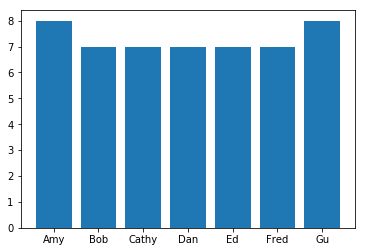

--------------------------------------------------
Assigments
Symbols: '-': not working, '*': working
  worker Mon1 Tue2 Wed3 Thu4 Fri5 Sat6 Sun7 Mon8 Tue9 Wed10 Thu11 Fri12 Sat13 Sun14
0    Amy    -    -    *    -    *    -    *    -    -     *     *     *     *     *
1    Bob    *    *    -    -    *    *    -    *    -     -     *     -     *     -
2  Cathy    -    -    *    *    -    -    *    -    -     *     *     *     *     -
3    Dan    -    -    *    -    *    *    -    -    *     -     *     *     *     -
4     Ed    *    -    -    *    *    -    *    *    -     -     -     -     *     *
5   Fred    *    *    *    -    -    *    -    -    -     -     -     *     *     *
6     Gu    -    -    -    -    *    *    *    -    *     *     -     *     *     *


In [20]:
# Print total slack and the number of shifts worked for each worker
# The KPIs for this optimization number is the number of extra worked required to satisfy 
# demand and the number of shifts that each employed worker is working.
solution = {}
shifts_sol = {}
solution['Total slack required'] = str(totSlack.X)
assignments_all = {}
gant={}

assignments = dict()
for [w, s] in availability:
    if x[w, s].x == 1:
        if w in assignments:
            assignments[w].append(s)
        else:
            assignments[w] = [s]

print('KPIs')
print(pd.DataFrame.from_records(list(solution.items()), columns=['KPI', 'Value']))
print('-'*50)

for w in workers:
    shifts_sol[w]=totShifts[w].X
    assignments_all[w]=assignments.get(w, [])

print('Shifts')
print(pd.DataFrame.from_records(list(shifts_sol.items()), columns=['Worker', 'Number of shifts']))
    
y_pos = np.arange(len(shifts_sol.keys())) 
plt.bar(y_pos,shifts_sol.values() , align='center')
plt.xticks(y_pos, shifts_sol.keys())
plt.show()

print('-'*50)
for w in assignments_all:
    gant[w] = [w]
    for d in shifts:
        gant[w].append('*' if d in assignments_all[w] else '-')

print('Assigments')
print('Symbols: \'-\': not working, \'*\': working')
pd.set_option('display.width', 1000)
print(pd.DataFrame.from_records(list(gant.values()), columns=['worker']+shifts))

Copyright © 2019 Gurobi Optimization, LLC